# Phase 4: The Operational Model - Classification

**Goal**: Train a Supervised Learning model (Classifier) to predict the customer segment (Cluster) for **new customers**.

## Objectives
1. Load the labeled dataset (Features + Cluster Labels from Phase 3).
2. Train a Classifier (Random Forest) to map *Behavioral Features* -> *Cluster*.
3. Evaluate performance (Precision, Recall, F1-Score).
4. Analyze Feature Importance (Which behaviors drive segmentation?).
5. Save the Model & Scaler for the Inference Pipeline (Phase 5).

## Why is this step necessary?
K-Means (Phase 3) is a batch process. To segment a *single new user* in real-time without re-running K-Means on the whole database, we use this "Operational Model".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set plotting style
sns.set(style="whitegrid")
%matplotlib inline

## 1. Load Data
We need two files:
1. `customer_features.csv`: The input features (X).
2. `customer_clusters.csv`: The target labels (y) generated in Phase 3.

In [2]:
# Load datasets
features_df = pd.read_csv('../data/customer_features.csv')
clusters_df = pd.read_csv('../data/customer_clusters.csv')

# Merge to create a labeled dataset
df = pd.merge(features_df, clusters_df, on='customer_id')

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (14825, 22)


,customer_id,Unnamed: 0,age,income,membership_days,total_amount,transaction_count,average_transaction_value,offer completed,offer received,...,bogo_completed,discount_completed,channel_web_count,channel_email_count,channel_mobile_count,channel_social_count,gender_F,gender_M,gender_O,cluster
0,0610b486422d4921ae7d2bf64640c50b,1,55,112000.0,376,77.01,3.0,25.670000,1.0,2.0,...,1.0,0.0,1.0,1.0,1.0,0.0,True,False,False,0
1,78afa995795e4d85b5d9ceeca43f5fef,3,75,100000.0,443,159.27,7.0,22.752857,3.0,4.0,...,3.0,0.0,4.0,7.0,7.0,5.0,True,False,False,3
2,e2127556f4f64592b11af22de27a7932,5,68,70000.0,91,57.73,3.0,19.243333,2.0,4.0,...,1.0,1.0,5.0,5.0,5.0,2.0,False,True,False,2
3,389bc3fa690240e798340f5a15918d5c,8,65,53000.0,167,36.43,3.0,12.143333,5.0,6.0,...,3.0,2.0,11.0,11.0,11.0,6.0,False,True,False,1
4,2eeac8d8feae4a8cad5a6af0499a211d,12,58,51000.0,257,15.62,4.0,3.905000,1.0,3.0,...,0.0,1.0,3.0,3.0,3.0,3.0,False,True,False,0


## 2. Preprocessing & Data Split

We must recreate the scaling process carefully.
*   **Split** data into Train and Test first.
*   **Fit** the Scaler ONLY on the Training set to avoid data leakage.
*   **Transform** the Test set using the fitted scaler.

In [3]:
# Define Features (X) and Target (y)
X = df.drop(columns=['customer_id', 'cluster'])  # Drop ID and Target
y = df['cluster']

# Split data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Testing shapes:  X={X_test.shape}, y={y_test.shape}")

# Initialize and Fit StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability nicely (optional but good for debugging)
feature_names = X.columns
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

Training shapes: X=(11860, 20), y=(11860,)
Testing shapes:  X=(2965, 20), y=(2965,)


## 3. Train Classification Model
We'll use a **Random Forest Classifier**. It's robust, handles non-linear relationships well, and provides feature importance.

In [4]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

# Train the model
rf_model.fit(X_train_scaled, y_train)

print("Model Training Completed.")

Model Training Completed.


## 4. Model Evaluation
How accurate is our model at assigning customers to the correct segment?

Model Accuracy: 96.19%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       861
           1       0.97      0.94      0.95       665
           2       0.96      0.97      0.96       730
           3       0.94      0.97      0.95       709

    accuracy                           0.96      2965
   macro avg       0.96      0.96      0.96      2965
weighted avg       0.96      0.96      0.96      2965



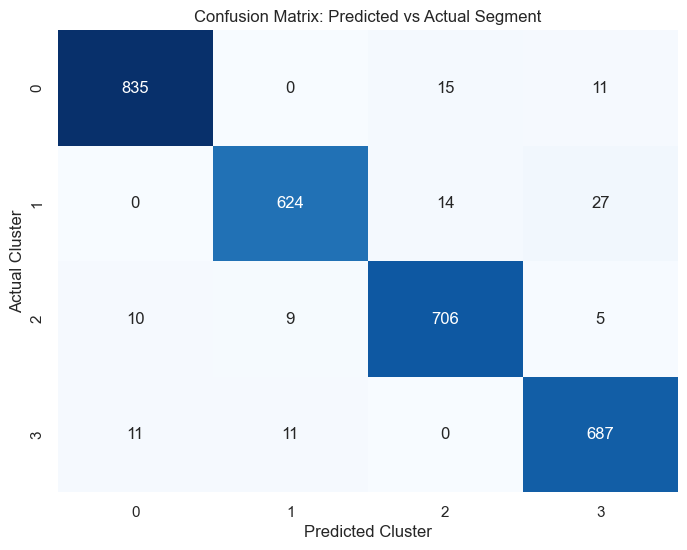

In [5]:
# Predict on Test Set
y_pred = rf_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Predicted vs Actual Segment')
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Cluster')
plt.show()

## 5. Feature Importance Analysis
Which features does the model rely on most to make decisions? This helps validate our segmentation logic.

C:\Users\phamt\AppData\Local\Temp\ipykernel_34680\2073364636.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10), palette='viridis')


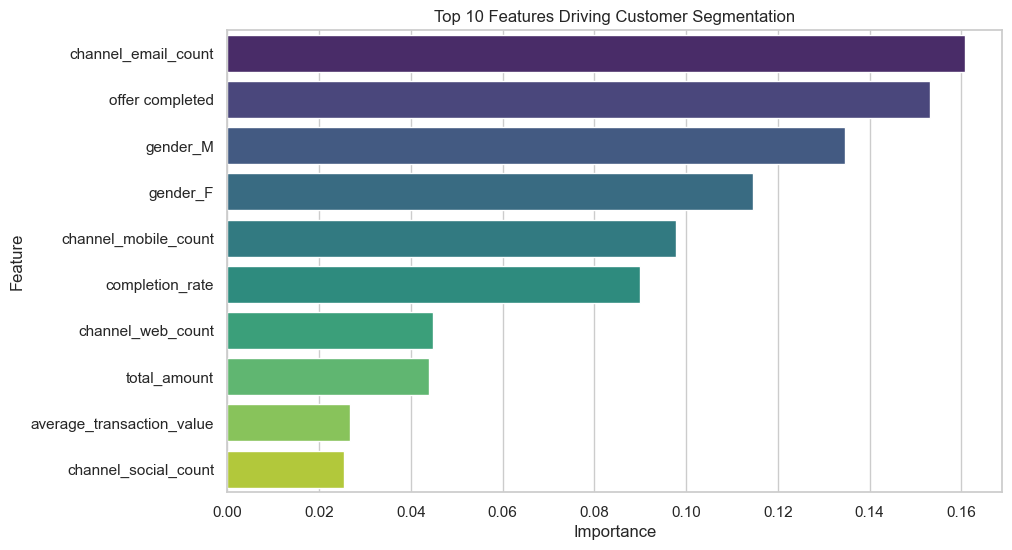

In [6]:
# Extract feature importances
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10), palette='viridis')
plt.title('Top 10 Features Driving Customer Segmentation')
plt.show()

## 6. Save Model Artifacts
We need to save the **Model** and the **Scaler** locally. These files will be loaded in Phase 5 to make predictions on new data.

In [7]:
# Ensure models directory exists
models_dir = '../models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the Scaler
joblib.dump(scaler, os.path.join(models_dir, 'customer_scaler.pkl'))
print(f"Scaler saved to {models_dir}/customer_scaler.pkl")

# Save the Classifier
joblib.dump(rf_model, os.path.join(models_dir, 'customer_classifier.pkl'))
print(f"Model saved to {models_dir}/customer_classifier.pkl")

Scaler saved to ../models/customer_scaler.pkl
Model saved to ../models/customer_classifier.pkl
